In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data_path='train.csv'
df=pd.read_csv(data_path)

base_image_dir='colored_images'

label_mapping={
    'No_DR':0,
    'Mild':1,
    'Moderate':2,
    'Severe':3,
    'Proliferate_DR':4
}

def preprocess_data(df,base_image_dir,label_mapping,img_size=(128,128)):
    images=[]
    labels=[]

    for index, row in df.iterrows():
        for label_name, label_num in label_mapping.items():
            img_dir=os.path.join(base_image_dir,label_name)
            img_path=os.path.join(img_dir,row['id_code']+'.png')
            if os.path.exists(img_path):
                image=cv2.imread(img_path)
                image=cv2.resize(image,img_size)
                image=image/255.0
                images.append(image)
                labels.append(label_num)

    images=np.array(images)
    labels=np.array(labels)
    labels=to_categorical(labels,num_classes=5)

    return images, labels

images, labels = preprocess_data(df,base_image_dir,label_mapping)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (2929, 128, 128, 3)
Validation data shape: (733, 128, 128, 3)


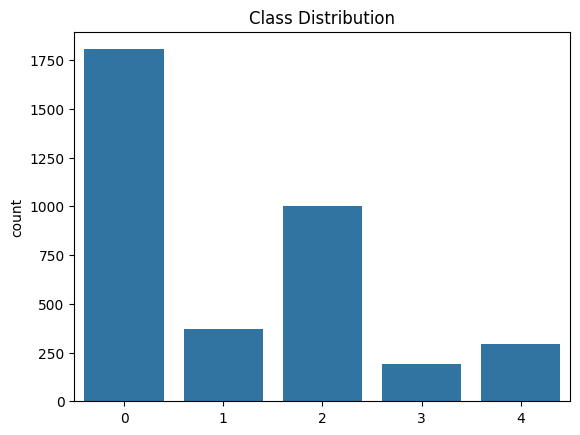

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=np.argmax(labels, axis=1))
plt.title("Class Distribution")
plt.show()

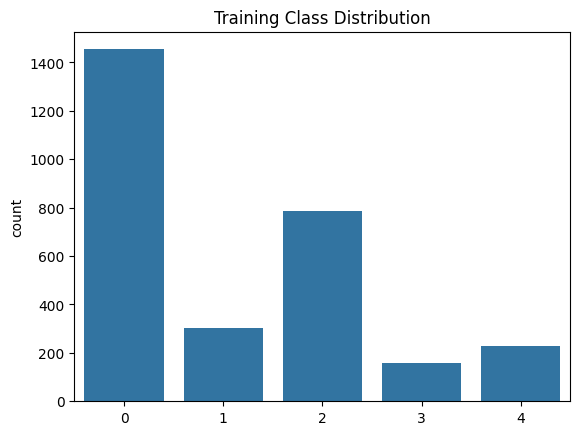

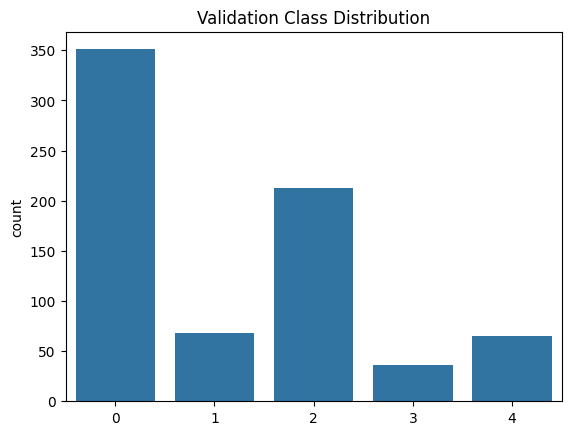

In [3]:
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title("Training Class Distribution")
plt.show()

sns.countplot(x=np.argmax(y_val, axis=1))
plt.title("Validation Class Distribution")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False  # No vertical flip for retinal images
)
datagen.fit(X_train)

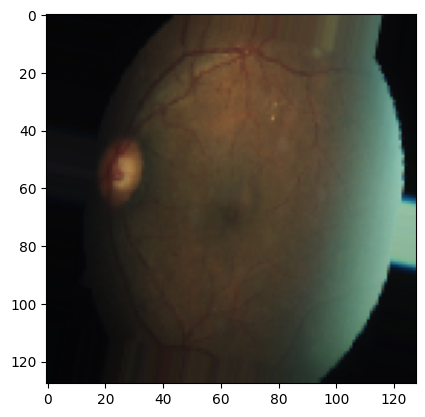

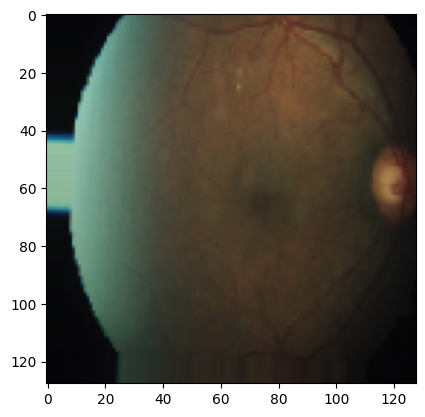

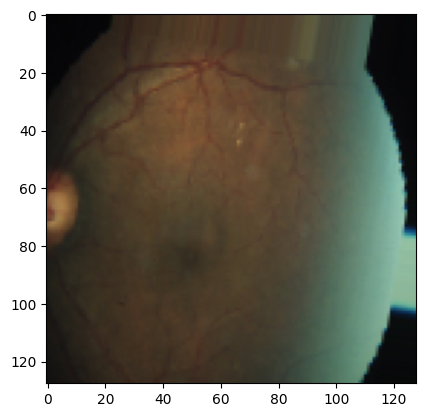

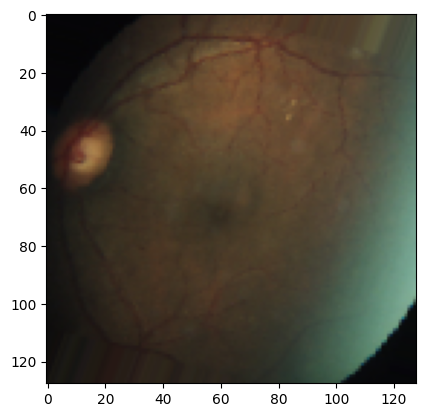

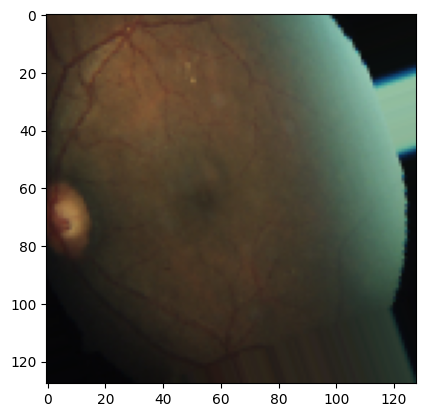

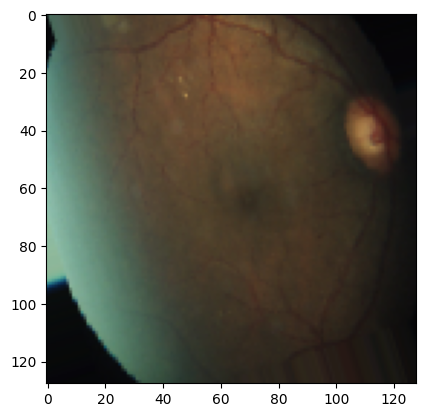

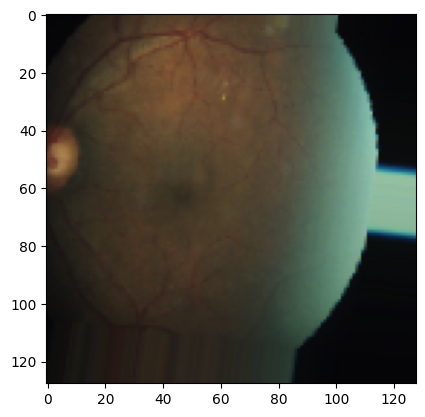

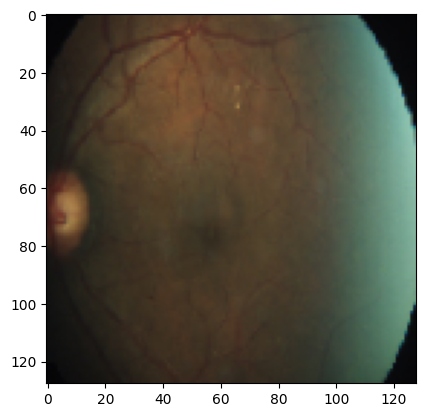

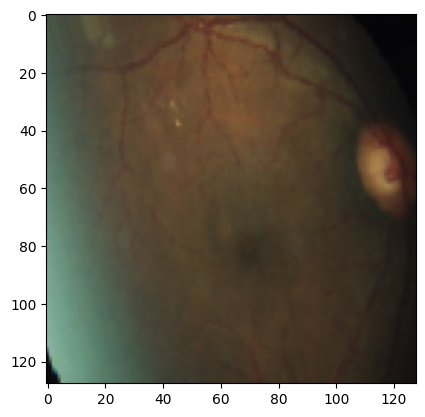

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load an example image
img_path = "colored_images/Mild/1b329a127307.png"
img = load_img(img_path, target_size=(128, 128)) # Adjust target_size as per your model input
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # Add batch dimension

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    plt.imshow(batch[0])
    i += 1
    if i % 9 == 0: # Display 9 augmented images
        break
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = labels.shape[1] # 5

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]), # X_train.shape[1:] = (128, 128, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'), # 예시로 256 뉴런 사용
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32
epochs = 50 # 초기 에포크 수. EarlyStopping에 의해 조절될 것임.

# 과적합 방지 및 최적 모델 저장 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size), # 증강된 학습 데이터 사용
    epochs=epochs,
    validation_data=(X_val, y_val), # 증강되지 않은 검증 데이터 사용 (중요!)
    callbacks=[early_stopping, model_checkpoint] # 콜백 추가
)

Epoch 1/50
92/92 [==============================] - 21s 118ms/step - loss: 1.3296 - accuracy: 0.4824 - val_loss: 3.3823 - val_accuracy: 0.4789
Epoch 2/50
92/92 [==============================] - 11s 117ms/step - loss: 1.3129 - accuracy: 0.4957 - val_loss: 4.4585 - val_accuracy: 0.4789
Epoch 3/50
92/92 [==============================] - 10s 104ms/step - loss: 1.3131 - accuracy: 0.4964 - val_loss: 6.3690 - val_accuracy: 0.4789
Epoch 4/50
92/92 [==============================] - 10s 106ms/step - loss: 1.3167 - accuracy: 0.4964 - val_loss: 3.2438 - val_accuracy: 0.4789
Epoch 5/50
92/92 [==============================] - 10s 106ms/step - loss: 1.3094 - accuracy: 0.4964 - val_loss: 3.0640 - val_accuracy: 0.4789
Epoch 6/50
92/92 [==============================] - 11s 117ms/step - loss: 1.3073 - accuracy: 0.4964 - val_loss: 3.2789 - val_accuracy: 0.4789
Epoch 7/50
92/92 [==============================] - 10s 106ms/step - loss: 1.3083 - accuracy: 0.4964 - val_loss: 2.5613 - val_accuracy: 0.4789